In [275]:
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import numpy as np
import seaborn as sns 
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [246]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape)
print(test.shape)
train.head(5)

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [247]:
price = train["SalePrice"]
all_data = pd.concat([train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']],ignore_index =True)

num_train = train.shape[0]
num_test = test.shape[0]

#eliminate the columns that contain too much NAN
temp = all_data.isnull().sum()
ratio = temp/all_data.shape[0]
cols = ratio > 0.3

print(str(all_data.columns[cols]))  # columns contain too much NAN
all_data = all_data.drop(all_data.columns[cols],axis =1 )




Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


In [248]:
print('Columns contain NAN :')
temp2 = all_data.isnull().sum() != 0
print(all_data[all_data.columns[temp2]].isnull().sum())

Columns contain NAN :
MSZoning          4
LotFrontage     486
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       24
MasVnrArea       23
BsmtQual         81
BsmtCond         82
BsmtExposure     82
BsmtFinType1     79
BsmtFinSF1        1
BsmtFinType2     80
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageType      157
GarageYrBlt     159
GarageFinish    159
GarageCars        1
GarageArea        1
GarageQual      159
GarageCond      159
SaleType          1
dtype: int64


In [249]:
# show the missing in specific category
def show_missing(houseprice):
    missing = houseprice.columns[houseprice.isnull().any()].tolist()
    return missing

# show the table of categorical feature
def cat_exploration(houseprice, column):
    print(houseprice[column].value_counts())



In [250]:
#MSZoning
cat_exploration(all_data, 'MSZoning')
print(all_data[all_data['MSZoning'].isnull() == True].index)

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
Int64Index([1915, 2216, 2250, 2904], dtype='int64')


In [251]:
#MSZoning are related
#print(all_data['LotFrontage'].corr(all_data['LotArea']))  ## 0.49
#replace the miss value with the 

print(pd.crosstab(all_data.MSSubClass, all_data.MSZoning))
all_data['MSSubClass'].loc[(all_data['MSSubClass'] == 20)&(all_data['MSZoning'].isnull()==True) ] = 'RL'
all_data['MSSubClass'].loc[(all_data['MSSubClass'] == 30)&(all_data['MSZoning'].isnull()==True) ] = 'RM'
all_data['MSSubClass'].loc[(all_data['MSSubClass'] == 70)&(all_data['MSZoning'].isnull()==True) ] = 'RM'

MSZoning    C (all)  FV  RH    RL   RM
MSSubClass                            
20                3  34   4  1016   20
30                8   0   2    61   67
40                0   0   0     4    2
45                0   0   1     6   11
50                7   0   2   159  119
60                0  43   0   529    3
70                4   0   3    57   63
75                0   0   0     9   14
80                0   0   0   115    3
85                0   0   0    47    1
90                0   0   4    92   13
120               0  19   6   117   40
150               0   0   0     1    0
160               0  43   0    21   64
180               0   0   0     0   17
190               3   0   4    31   23


C:\Users\Mission\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [252]:
#distribution are really unbalance, so we don't consider this factor
print(cat_exploration(train, 'Utilities'))
all_data = all_data.drop('Utilities', axis = 1)

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
None


In [253]:
# Exterior1st & Exterior2nd
cat_exploration(test, 'Exterior1st')
cat_exploration(train, 'Exterior1st')
cat_exploration(all_data, 'Exterior2nd')


all_data.loc[all_data['Exterior1st'].isnull(), 'Exterior1st'] = 'VinylSd'
all_data.loc[all_data['Exterior2nd'].isnull(), 'Exterior2nd'] = 'VinylSd'


VinylSd    510
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
CemntBd     65
BrkFace     37
WdShing     30
AsbShng     24
Stucco      18
BrkComm      4
CBlock       1
AsphShn      1
Name: Exterior1st, dtype: int64
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
ImStucc      1
CBlock       1
AsphShn      1
Name: Exterior1st, dtype: int64
VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
BrkFace      47
Stucco       47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64


In [254]:
# MasVnrType & MasVnrArea
#print(cat_exploration(all_data, 'MasVnrType'))
#print(all_data[all_data['MasVnrType'].isnull() == True])
#print(cat_exploration(all_data, 'MasVnrArea'))
#print(all_data[all_data['MasVnrArea'].isnull() == True])
all_data.loc[all_data['MasVnrType'].isnull() == True, 'MasVnrType'] = 'none'
all_data.loc[all_data['MasVnrArea'].isnull() == True, 'MasVnrArea'] = 0

In [255]:
# basement
basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
basement_area = ['BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']

for base in basement_cols:
    all_data[base].loc[all_data[base].isnull() == True] = 'unknown'


for area in basement_area:    
    #mean = np.mean(all_data[area])
    #print(mean)
    all_data[area].fillna(0,inplace = True)
    
#print(cat_exploration(all_data, 'BsmtFinType1'))
#print(all_data.loc[all_data['BsmtFinSF1'].isnull() == True])
all_data = all_data.replace({'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'unknown': 0}})
all_data = all_data.replace({'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'unknown': 0}})

C:\Users\Mission\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [256]:
#Functional
cat_exploration(all_data, 'Functional')
all_data['Functional'].loc[all_data['Functional'].isnull() == True] = 'Typ'


Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64


C:\Users\Mission\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [257]:
#Electrical
cat_exploration(all_data, 'Electrical')
all_data['Electrical'].loc[all_data['Electrical'].isnull() == True] = 'SBrkr'

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64


C:\Users\Mission\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [258]:
#BsmtFullBath
cat_exploration(all_data, 'BsmtFullBath')
all_data['BsmtFullBath'].loc[all_data['BsmtFullBath'].isnull() == True] = 0
cat_exploration(all_data, 'BsmtHalfBath')
all_data['BsmtHalfBath'].loc[all_data['BsmtHalfBath'].isnull() == True] = 0


0.0    1705
1.0    1172
2.0      38
3.0       2
Name: BsmtFullBath, dtype: int64
0.0    2742
1.0     171
2.0       4
Name: BsmtHalfBath, dtype: int64


C:\Users\Mission\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [259]:
#KitchenQual
cat_exploration(all_data, 'KitchenQual')
all_data['KitchenQual'].loc[all_data['KitchenQual'].isnull() == True] = 'TA'
all_data = all_data.replace({'KitchenQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}})

TA    1492
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64


C:\Users\Mission\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [260]:
#Garage
garage_cols = ['GarageType', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea']
for gar in garage_cols:
    cat_exploration(all_data, gar)
    
all_data['GarageType'].loc[all_data['GarageType'].isnull() == True] = 'Attchd'    
all_data['GarageQual'].loc[all_data['GarageQual'].isnull() == True] = 'TA'   
all_data['GarageCond'].loc[all_data['GarageCond'].isnull() == True] = 'TA'   
all_data = all_data.replace({'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 }})
all_data = all_data.replace({'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1 }})



all_data['GarageCars'].loc[all_data['GarageCars'].isnull() == True] = '2'
GA = all_data['GarageArea'].mean()
all_data['GarageArea'].fillna(GA,inplace = True)


Attchd     1723
Detchd      779
BuiltIn     186
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64
TA    2604
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64
TA    2654
Fa      74
Gd      15
Po      14
Ex       3
Name: GarageCond, dtype: int64
2005.0    142
2007.0    115
2006.0    115
2004.0     99
2003.0     92
1977.0     66
2008.0     61
1998.0     58
2000.0     55
1999.0     54
2002.0     53
1950.0     51
1976.0     50
1993.0     49
1968.0     48
1997.0     44
1958.0     42
1978.0     41
2001.0     41
1956.0     41
1996.0     40
1966.0     39
1994.0     39
1954.0     37
1960.0     37
1959.0     36
1967.0     36
1964.0     35
1974.0     35
1979.0     35
         ... 
1924.0      8
1935.0      8
1922.0      8
1936.0      7
1915.0      7
1928.0      7
1942.0      6
1937.0      6
1900.0      6
1916.0      6
1923.0      6
1921.0      5
2010.0      5
1927.0      5
1947.0      5
1931.0      4
1932.0      4
1934.0      4
1918.0      3
1

C:\Users\Mission\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [261]:
# LotFrontage
# check correlation with LotArea
print(all_data['LotFrontage'].corr(all_data['LotArea']))  
all_data['SqrtLotArea'] = np.sqrt(all_data['LotArea'])

cond = all_data['LotFrontage'].isnull()
all_data.LotFrontage[cond] = all_data.SqrtLotArea[cond]

del all_data['SqrtLotArea']


0.489895570387


C:\Users\Mission\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [262]:
#transform GarageYrBlt to years
mean_year = all_data['GarageYrBlt'].mean()

all_data['GarageYrBlt'].fillna(int(mean_year),inplace = True)
all_data.loc[all_data['GarageYrBlt'] == 2207,'GarageYrBlt'] = mean_year

data_sortbydate = all_data.sort_values(by = 'GarageYrBlt')
lastday = data_sortbydate['GarageYrBlt'].iloc[len(data_sortbydate)-1]
print(lastday)

all_data['date_diff'] = all_data['GarageYrBlt'].apply(lambda x : lastday - x) 
del all_data['GarageYrBlt'] 

2010.0


In [263]:
#YearBuilt
data_builddate = all_data.sort_values(by = 'YearBuilt')
lastbday = data_builddate['YearBuilt'].iloc[len(data_builddate)-1]
all_data['build_date'] = all_data['YearBuilt'].apply(lambda x : lastbday - x) 
del all_data['YearBuilt'] 

In [264]:
#YearBuilt
data_rmdate = all_data.sort_values(by = 'YearRemodAdd')
lastbday_rm = data_rmdate['YearRemodAdd'].iloc[len(data_rmdate)-1]
all_data['rm_date'] = all_data['YearRemodAdd'].apply(lambda x : lastbday_rm - x) 
del all_data['YearRemodAdd'] 

In [265]:
#SaleType      
cat_exploration(test, 'SaleType')
all_data['SaleType'].loc[all_data['SaleType'].isnull() == True] = 'WD'

WD       1258
New       117
COD        44
ConLD      17
CWD         8
Oth         4
ConLI       4
ConLw       3
Con         3
Name: SaleType, dtype: int64


C:\Users\Mission\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Remove the outlier


,GrLivArea,SalePrice
1298,5642.0,160000
523,4676.0,184750
1182,4476.0,745000
691,4316.0,755000
1169,3627.0,625000


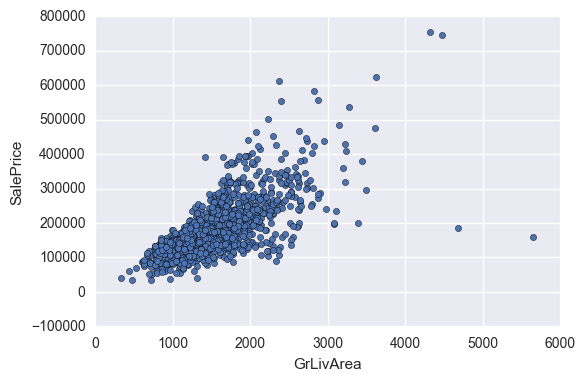

In [266]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([all_data[var].iloc[:train.shape[0]-1],train['SalePrice']],axis =1)
data.plot.scatter(x =var, y='SalePrice')

#delete the  point on the down-right side, these two point do not follow the trend <== outlier
temp = data.sort_values(by = 'GrLivArea',ascending = False)
temp.head(5)


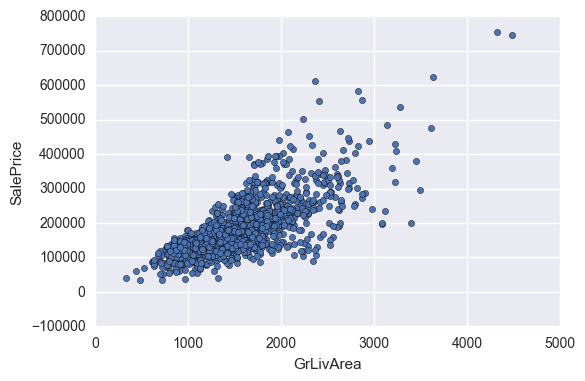

In [267]:
all_data = all_data.drop(all_data[all_data.index == 1298].index)
all_data = all_data.drop(all_data[all_data.index == 523].index)
price = price.drop(price[price.index == 1298].index)
price = price.drop(price[price.index == 523].index)
data = pd.concat([all_data[var].iloc[:train.shape[0]-1],train['SalePrice']],axis =1)
data.plot.scatter(x =var, y='SalePrice')


Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea',
       'date_diff'],
      dtype='object')
LotFrontage
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
GarageArea
date_diff


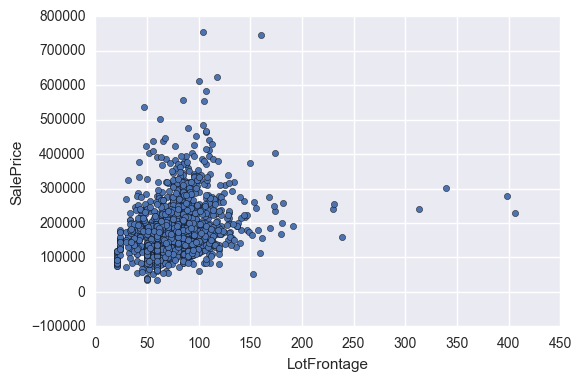

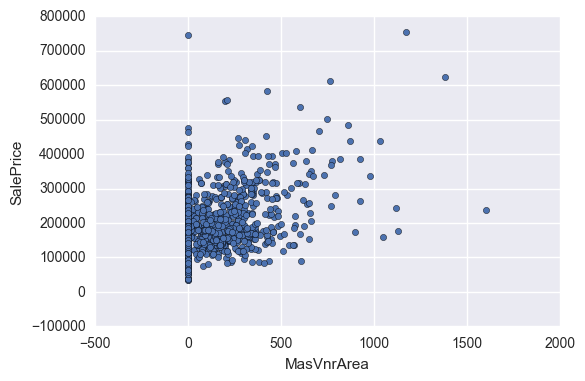

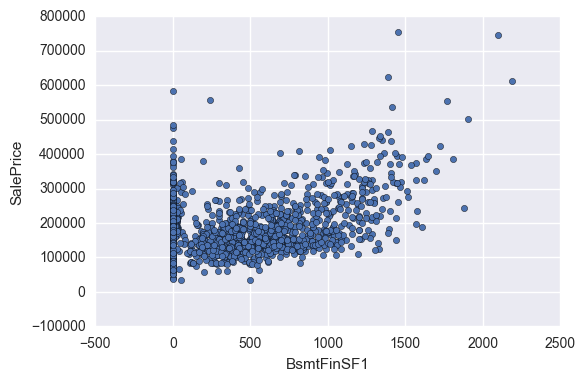

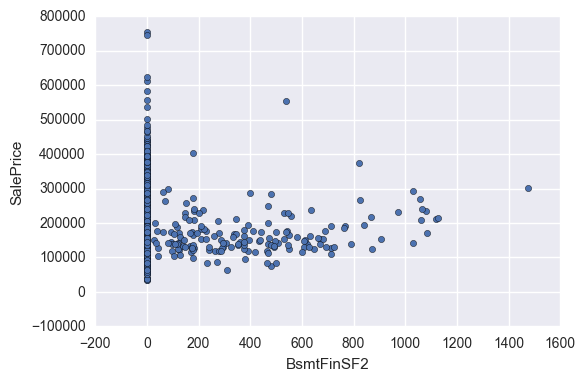

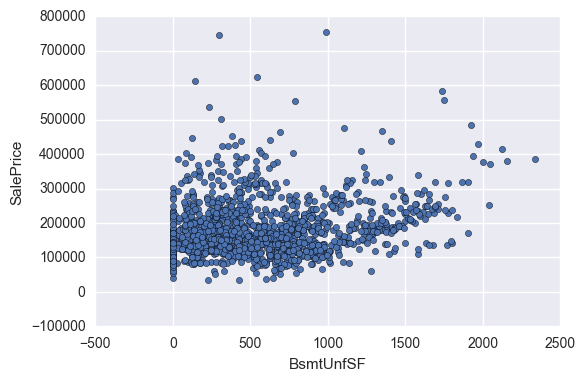

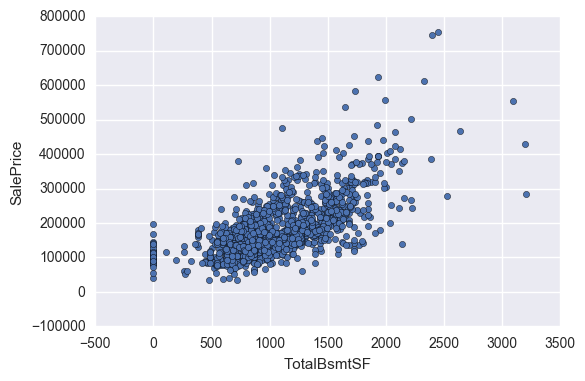

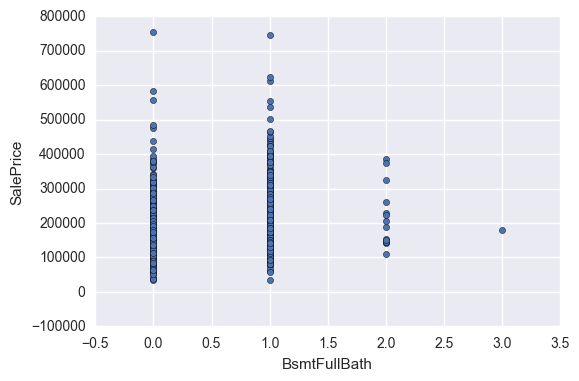

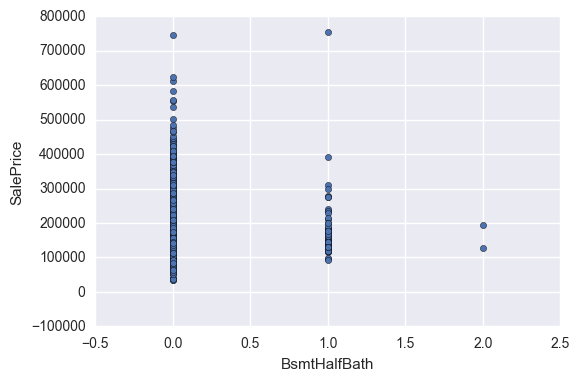

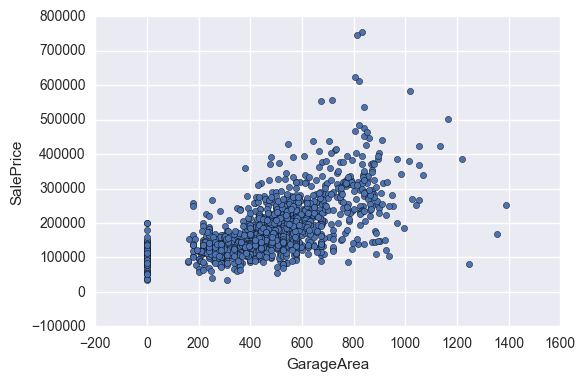

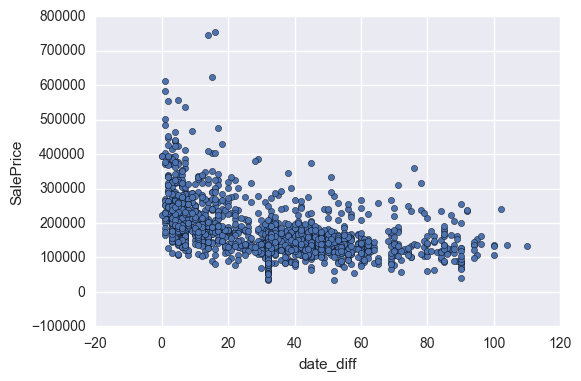

In [268]:
#explore the data
col_ind = all_data.dtypes[all_data.dtypes == "float64"].index
col_float = all_data[col_ind].columns
print(col_float)


train_num = train.shape[0] -2
for col in col_float:
    print(col)
    data = pd.concat([all_data[col].iloc[:train_num-1],train['SalePrice']],axis =1)
    data.plot.scatter(x =col, y='SalePrice')


      GarageArea  SalePrice
581       1390.0     253293
1190      1356.0     168000
1061      1248.0      81000
825       1220.0     385000
178       1166.0     501837


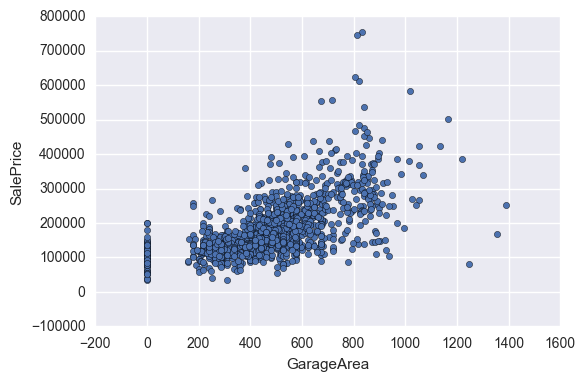

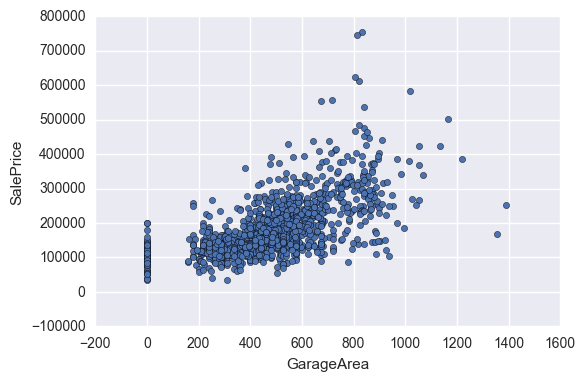

In [269]:
#delete the  point on the down-right side, these two point do not follow the trend <== outlier
data = pd.concat([all_data['GarageArea'].iloc[:train_num],price],axis =1)
data.plot.scatter(x ='GarageArea', y='SalePrice')
temp = data.sort_values(by ='GarageArea',ascending = False)
print(temp.head(5))


all_data = all_data.drop(all_data[all_data.index == 1061].index)
price = price.drop(price[price.index == 1061].index)
train_num = train.shape[0] -3

data = pd.concat([all_data['GarageArea'].iloc[:train_num],price],axis =1)
data.plot.scatter(x ='GarageArea', y='SalePrice')

      OpenPorchSF  SalePrice
1328          547     256000
495           523      34900
583           502     325000
854           418     170000
875           364     303477


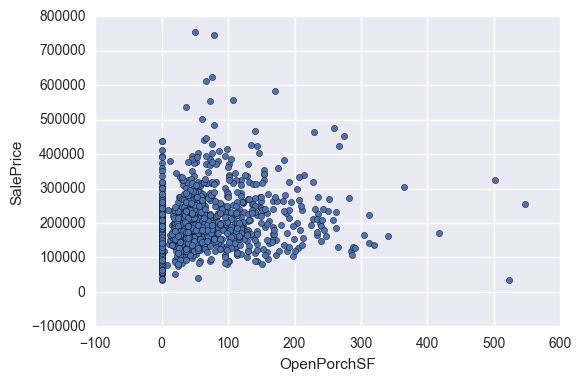

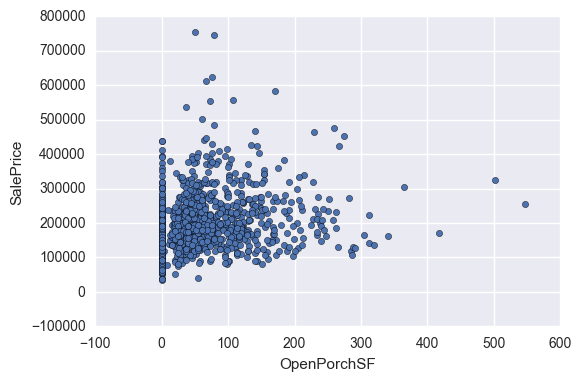

In [270]:
#delete the  point on the down-right side, these two point do not follow the trend <== outlier
data = pd.concat([all_data['OpenPorchSF'].iloc[:train_num],price],axis =1)
data.plot.scatter(x ='OpenPorchSF', y='SalePrice')
temp = data.sort_values(by ='OpenPorchSF',ascending = False)
print(temp.head(5))


all_data = all_data.drop(all_data[all_data.index == 495].index)
price = price.drop(price[price.index == 495].index)
train_num = train.shape[0] -4

data = pd.concat([all_data['OpenPorchSF'].iloc[:train_num],price],axis =1)
data.plot.scatter(x ='OpenPorchSF', y='SalePrice')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000374F164208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000003751B78278>]], dtype=object)

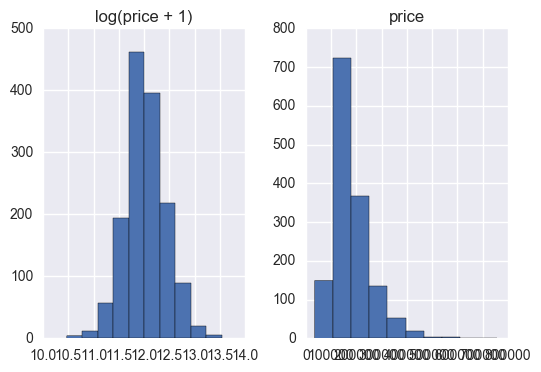

In [271]:
#transform the skewed numeric features by taking log(feature + 1) 
#this will make the features more normal
prices = pd.DataFrame({"price":price, "log(price + 1)":np.log1p(price)})
prices.hist()

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

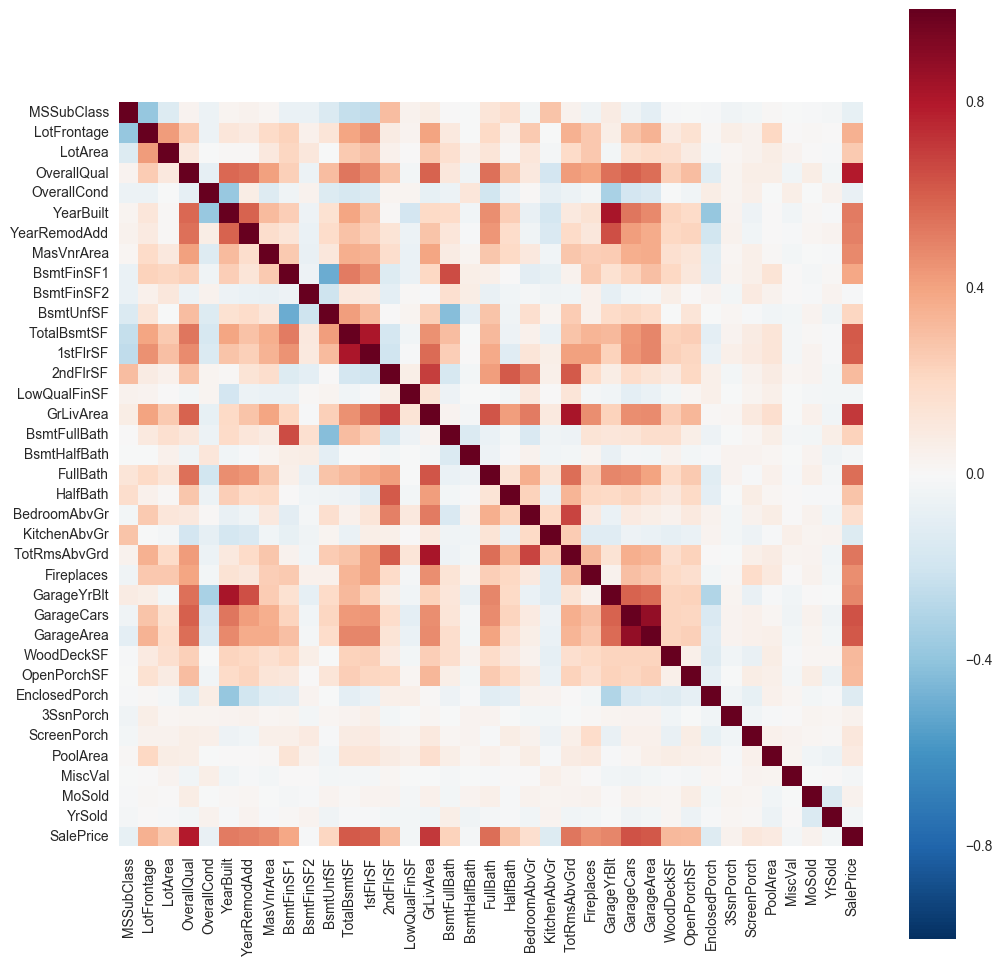

In [272]:
#corr map
corr = train.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)

In [273]:
#transform categorical data to dummy data
for col in all_data.columns:
    if all_data[col].dtype == np.object:
        all_data = pd.concat((all_data, pd.get_dummies(all_data[col], prefix= col)), axis = 1)
        del all_data[col]

In [274]:
x_train = all_data[:train_num]
x_test = all_data.iloc[train_num:]
y_train = np.log1p(price)

#all_data.to_csv('all_data.csv')
#y_train.to_csv('y_train.csv')

In [276]:
"""
select the importance feature
"""

rf = RandomForestRegressor(n_estimators=400)
train_y = y_train
train_x = x_train
rf.fit(train_x, train_y)

y_train_rf = rf.predict(x_train)
y_pred_rf = rf.predict(x_test)
score = mean_squared_error(y_train_rf,y_train)
print(score)

imp = rf.feature_importances_
imp = pd.DataFrame({'feature': x_train.columns, 'score': imp})
print(imp.sort(['score'], ascending=[0]))  # sort the importance of the feature
imp = imp.sort(['score'], ascending=[0])

0.00246849371607
                  feature         score
2             OverallQual  5.488016e-01
14              GrLivArea  1.137329e-01
10            TotalBsmtSF  5.217550e-02
24             GarageArea  3.322721e-02
7              BsmtFinSF1  2.240045e-02
11               1stFlrSF  2.239455e-02
255        GarageCars_3.0  1.918074e-02
37             build_date  1.568875e-02
254        GarageCars_2.0  1.543430e-02
3             OverallCond  1.190370e-02
1                 LotArea  1.182682e-02
38                rm_date  8.050866e-03
0             LotFrontage  6.426235e-03
230          CentralAir_Y  5.538128e-03
9               BsmtUnfSF  5.489613e-03
23             Fireplaces  5.178266e-03
229          CentralAir_N  5.002659e-03
5                BsmtQual  4.851165e-03
12               2ndFlrSF  4.603019e-03
36              date_diff  3.807763e-03
248     GarageType_Detchd  3.705235e-03
61            MSZoning_RM  3.699717e-03
21            KitchenQual  3.329756e-03
28            OpenPorch

C:\Users\Mission\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\Mission\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


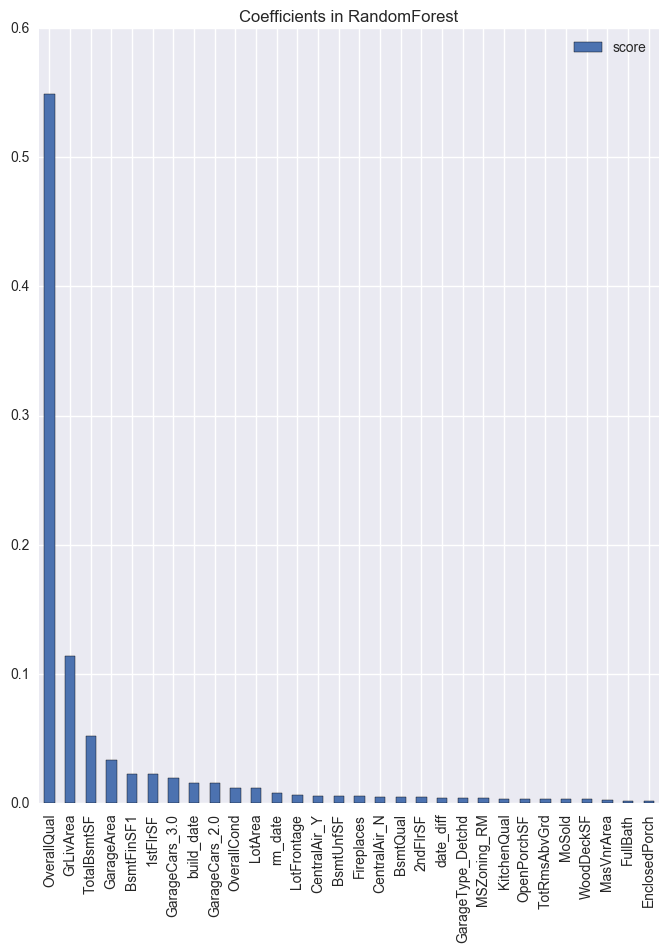

In [292]:
#imp_f = pd.DataFrame({'feature': x_train.columns, 'score': imp})
#imp_coef = pd.concat([imp.sort_values('score').head(10),imp.sort_values('score').tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp.iloc[0:30].plot(kind = "bar")
plt.xticks(range(len(imp.iloc[0:30])),imp['feature'].iloc[0:30])
plt.title("Coefficients in RandomForest")